# Optimization Algorithms from Scratch (NumPy)
**Objective:** Implement and compare SGD, Momentum, and Adam optimizers on a custom MLP to understand convergence speed and stability.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

## Problem Setup (Minimal)
**Optimization** is the engine of Deep Learning. Finding the minimum of a high-dimensional non-convex loss surface is efficient only with the right algorithms.

*   **SGD (Stochastic Gradient Descent):** Updates parameters using the gradient of a mini-batch. Can be noisy and slow in ravines.
*   **Momentum:** Accumulates a "velocity" of past gradients to smooth out noise and accelerate in the right direction.
*   **Adam (Adaptive Moment Estimation):** Adapts individual learning rates for each parameter using estimates of first (mean) and second (variance) moments of the gradients.

## Data

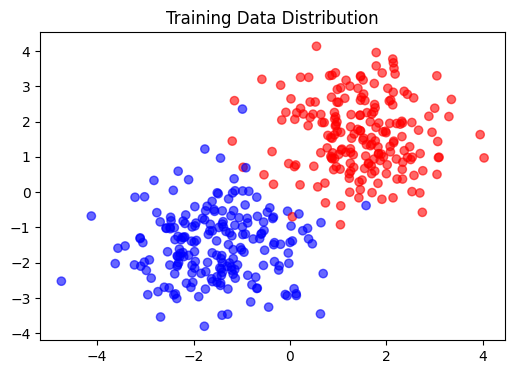

In [2]:
# Generate Synthetic Binary Data (Two Gaussian Clusters)
n_samples = 500
# Two centers somewhat close to make optimization non-trivial
X0 = np.random.randn(n_samples // 2, 2) + np.array([-1.5, -1.5])
X1 = np.random.randn(n_samples // 2, 2) + np.array([1.5, 1.5])
X = np.vstack([X0, X1])

y0 = np.zeros((n_samples // 2, 1))
y1 = np.ones((n_samples // 2, 1))
y = np.vstack([y0, y1])

# Shuffle and Split
indices = np.arange(n_samples)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

split = int(0.8 * n_samples)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Visualize
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), cmap='bwr', alpha=0.6)
plt.title("Training Data Distribution")
plt.show()

## Model (Reuse)
Reusing our MLP architecture (Linear -> ReLU -> Linear -> Sigmoid).

In [3]:
# Activation Functions
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

# Initialization
def init_params(d_in, d_hidden, d_out):
    # He Initialization
    W1 = np.random.randn(d_in, d_hidden) * np.sqrt(2 / d_in)
    b1 = np.zeros((1, d_hidden))
    W2 = np.random.randn(d_hidden, d_out) * np.sqrt(2 / d_hidden)
    b2 = np.zeros((1, d_out))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# Forward Pass
def forward(X, params):
    Z1 = X.dot(params["W1"]) + params["b1"]
    A1 = relu(Z1)
    Z2 = A1.dot(params["W2"]) + params["b2"]
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return cache, A2

# Loss
def compute_loss(y, y_prob):
    epsilon = 1e-15
    m = y.shape[0]
    loss = -1/m * np.sum(y * np.log(y_prob + epsilon) + (1 - y) * np.log(1 - y_prob + epsilon))
    return loss

# Backward Pass
def backward(X, y, y_prob, cache, params):
    m = X.shape[0]
    dZ2 = y_prob - y
    dW2 = (1/m) * cache["A1"].T.dot(dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
    
    dA1 = dZ2.dot(params["W2"].T)
    dZ1 = dA1 * relu_deriv(cache["Z1"])
    dW1 = (1/m) * X.T.dot(dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
    
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def predict(X, params):
    _, y_prob = forward(X, params)
    return (y_prob >= 0.5).astype(int)

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

## Optimizers (NumPy)

In [4]:
# A) Data Class for Optimizer State
# Typically we need to store velocities (v) or moment estimates (m, v) separate from params

def init_optimizer_state(params, optimizer_type):
    state = {}
    if optimizer_type == "sgd":
        pass # No state needed
    elif optimizer_type == "momentum":
        for key in params:
            state[key] = np.zeros_like(params[key]) # Velocity initialized to 0
    elif optimizer_type == "adam":
        state["t"] = 0
        for key in params:
            state["m_" + key] = np.zeros_like(params[key]) # 1st moment
            state["v_" + key] = np.zeros_like(params[key]) # 2nd moment
    return state

# B) Update Rules

def update_sgd(params, grads, lr, state=None):
    for key in params:
        params[key] -= lr * grads["d" + key]
    return params, state

def update_momentum(params, grads, lr, state, beta=0.9):
    for key in params:
        # v = beta * v_old + (1 - beta) * grad (or usually just beta*v - lr*grad)
        # Classic momentum update: v = beta * v - lr * grad
        # But PyTorch/common impl: v = beta * v + grad; param -= lr * v
        # Let's use the "velocity accumulation" form:
        velocity = state[key]
        velocity = beta * velocity + (1 - beta) * grads["d" + key]
        state[key] = velocity
        
        params[key] -= lr * velocity
    return params, state

def update_adam(params, grads, lr, state, beta1=0.9, beta2=0.999, eps=1e-8):
    state["t"] += 1
    t = state["t"]
    
    for key in params:
        grad = grads["d" + key]
        m = state["m_" + key]
        v = state["v_" + key]
        
        # Update biased first moment estimate
        m = beta1 * m + (1 - beta1) * grad
        # Update biased second raw moment estimate
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        # Compute bias-corrected first moment estimate
        m_hat = m / (1 - beta1 ** t)
        # Compute bias-corrected second raw moment estimate
        v_hat = v / (1 - beta2 ** t)
        
        # Update parameters
        people_param_update = lr * m_hat / (np.sqrt(v_hat) + eps)
        params[key] -= people_param_update
        
        # Store state back
        state["m_" + key] = m
        state["v_" + key] = v
        
    return params, state

## Training Loop

In [5]:
def train(X_train, y_train, X_test, y_test, optimizer_name="sgd", lr=0.01, epochs=100):
    # Initialize Model
    params = init_params(d_in=2, d_hidden=10, d_out=1)
    state = init_optimizer_state(params, optimizer_name)
    
    history_loss = []
    history_acc = []
    
    for i in range(epochs):
        # 1. Forward
        cache, y_prob = forward(X_train, params)
        loss = compute_loss(y_train, y_prob)
        
        # Check Divergence
        if np.isnan(loss) or np.isinf(loss):
            print(f"Training diverged at epoch {i} with {optimizer_name}!")
            break
            
        # 2. Backward
        grads = backward(X_train, y_train, y_prob, cache, params)
        
        # 3. Update
        if optimizer_name == "sgd":
            params, state = update_sgd(params, grads, lr, state)
        elif optimizer_name == "momentum":
            params, state = update_momentum(params, grads, lr, state)
        elif optimizer_name == "adam":
            params, state = update_adam(params, grads, lr, state)
            
        # Log
        history_loss.append(loss)
        
        if i % 10 == 0: # Check test acc occasionally
            y_pred_test = predict(X_test, params)
            acc = accuracy(y_test, y_pred_test)
            history_acc.append(acc)
            
    print(f"Finished {optimizer_name.upper()} - Final Loss: {loss:.4f}")
    return history_loss, history_acc, params

## Experiments (Comparison)

Finished SGD - Final Loss: 0.0406
Finished MOMENTUM - Final Loss: 0.0409
Finished ADAM - Final Loss: 0.0341


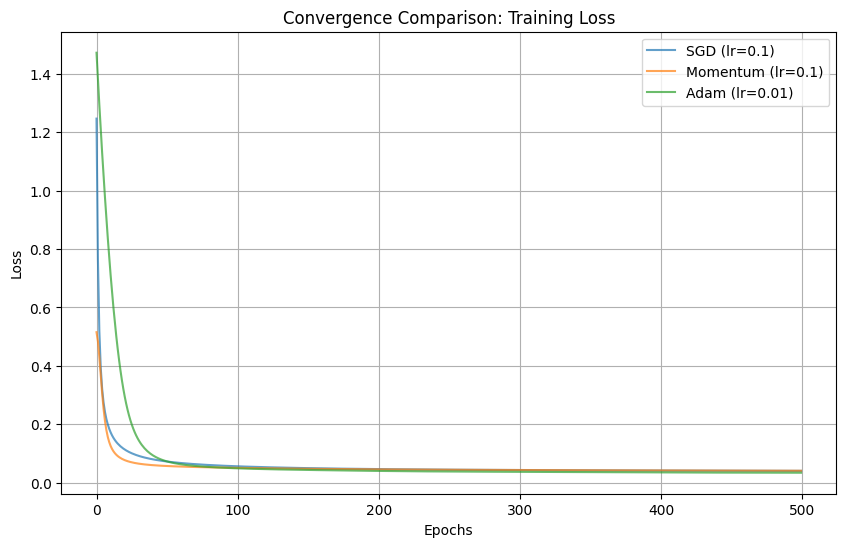

In [6]:
epochs = 500

# 1. SGD (Common Baseline)
loss_sgd, acc_sgd, _ = train(X_train, y_train, X_test, y_test, "sgd", lr=0.1, epochs=epochs)

# 2. Momentum (Faster in consistent directions)
loss_mom, acc_mom, _ = train(X_train, y_train, X_test, y_test, "momentum", lr=0.1, epochs=epochs)

# 3. Adam (Adaptive learning rates)
loss_adam, acc_adam, _ = train(X_train, y_train, X_test, y_test, "adam", lr=0.01, epochs=epochs)

# Plotting Comparison
plt.figure(figsize=(10, 6))
plt.plot(loss_sgd, label='SGD (lr=0.1)', alpha=0.7)
plt.plot(loss_mom, label='Momentum (lr=0.1)', alpha=0.7)
plt.plot(loss_adam, label='Adam (lr=0.01)', alpha=0.7)
plt.title("Convergence Comparison: Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Sensitivity to Learning Rate
Demonstrating what happens when LR is aggressive.

aggressive LR Experiment (LR=0.5)...
Finished SGD - Final Loss: 0.0376
Finished ADAM - Final Loss: 0.0235


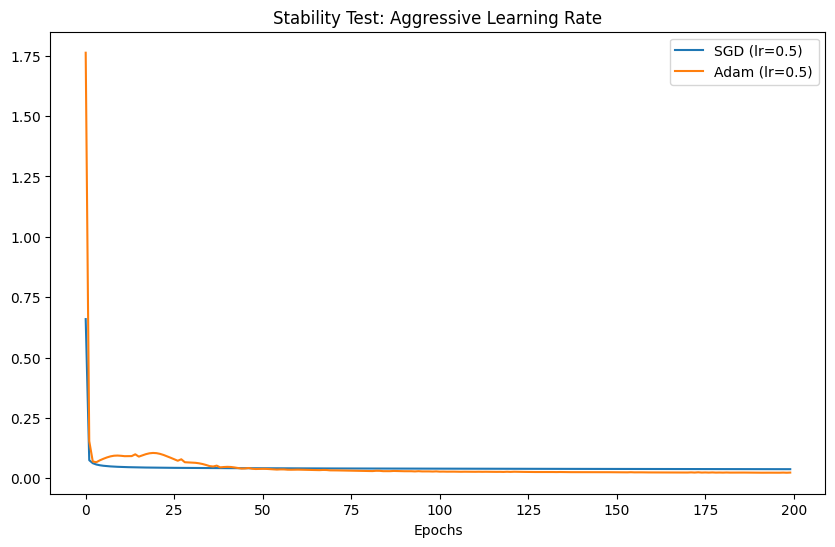

Observation: Adam typically handles high LR better or converges extremely fast, whereas SGD might oscillate or stall.


In [7]:
print("aggressive LR Experiment (LR=0.5)...")
loss_sgd_high, _, _ = train(X_train, y_train, X_test, y_test, "sgd", lr=0.5, epochs=200)
loss_adam_high, _, _ = train(X_train, y_train, X_test, y_test, "adam", lr=0.5, epochs=200)

plt.figure(figsize=(10, 6))
plt.plot(loss_sgd_high, label='SGD (lr=0.5)')
plt.plot(loss_adam_high, label='Adam (lr=0.5)')
plt.title("Stability Test: Aggressive Learning Rate")
plt.xlabel("Epochs")
plt.legend()
plt.show()
print("Observation: Adam typically handles high LR better or converges extremely fast, whereas SGD might oscillate or stall.")

## Results & Takeaways
*   **Speed:** Adam generally converges fastest in terms of epochs because it adapts the learning rate per parameter. It "zooms in" on the right direction quickly.
*   **Stability:** Momentum helps smooth out the noisy gradients of SGD (or mini-batches), reducing oscillation in "ravines" of the loss function.
*   **Tuning:** 
    *   SGD requires careful tuning of the global learning rate.
    *   Adam is robust to default hyperparameters (lr=0.01 or 0.001 usually works).
*   **Memory:** Adam requires storing more state (m and v for every parameter), effectively tripling memory usage for weights compared to plain SGD. Momentum doubles it.

## Next Steps
*   Move from Multi-Layer Perceptrons to **Convolutional Neural Networks (CNNs)** for Image Processing.
*   **Note:** The next project will involve larger datasets (like CIFAR-10) and should ideally be run on **Google Colab** (GPU).
*   [Go to Image Classification Project](../cnn/image-classification-project.ipynb)